In [26]:
from global_setup import _CONN_PARAMS_DIC
from databaseLoad import read_postgres_from_queryfile
import plotly.express as px
import numpy
import math
import pandas
import geopandas as gpd
#import folium
import bokeh
import datetime

# Set Limit for displaying columns to None
pandas.set_option('max_columns', None)

# Path to sql query files
SQL_PATH = r"./sqlCommands/"
SQL_DATA = r"loadMastrWind.sql"

SQL_DATA_PATH = SQL_PATH + SQL_DATA

def filter_wrong_bundeslaender(df:pandas.DataFrame) -> pandas.DataFrame:
    unique_bundesl = df["Bundesland"].unique()
    wrong_bundesl = [ i for i in unique_bundesl if not isinstance(i, str) and str(i) != 'nan']
    
    for wrong in wrong_bundesl:
        wrong_raws = df.loc[df["Bundesland"]==wrong]

        for index, raw in wrong_raws.iterrows():
            gmshl_of_wrong_raw = raw["Gemeindeschluessel"]
            most_common_bundesland = df.loc[df["Gemeindeschluessel"]==gmshl_of_wrong_raw]["Bundesland"].value_counts().index[0]
            df.loc[index,"Bundesland"] = most_common_bundesland

    return df

In [7]:
bundesländer = {
    1400:"Brandenburg",
    1401:"Berlin",
    1402:"Baden-Würtenberg",
    1403:"Bayern",
    1404:"Bremen",
    1405:"Hessen",
    1406:"Hamburg",
    1407:"Mecklenburg-Vorpommern",
    1408:"Niedersachsen",
    1409:"Nordrhein-Westfahlen",
    1410:"Rheinland-Pfalz",
    1411:"Schleswig-Holstein",
    1412:"Saarland",
    1413:"Sachsen",
    1414:"Sachsen-Anhalt",
    1415:"Thüringen"}

In [8]:
dfMastrWind = read_postgres_from_queryfile(
        sql_query_path = SQL_DATA_PATH,
        db_conn_data = _CONN_PARAMS_DIC
        )

dfMastrWind['SpezifischeLeistung'] = (dfMastrWind.Nettonennleistung * 1000) / (math.pi * (dfMastrWind.Rotordurchmesser / 2)**2)
dfMastrWind["Anlagenzahl"] = 1

# Korrigieren von Größenfehlern in der Nettonennleistung
dfMastrWind["Nettonennleistung"] = numpy.where(dfMastrWind["Nettonennleistung"] > 10, dfMastrWind["Nettonennleistung"] / 1000, dfMastrWind["Nettonennleistung"])

# Grobe Vereinheitlichung der Typbezeichnungen
dfMastrWind["Typenbezeichnung"] = dfMastrWind["Typenbezeichnung"].str.replace(' ', '')
dfMastrWind["Typenbezeichnung"] = dfMastrWind["Typenbezeichnung"].str.replace(',', '.')
dfMastrWind["Typenbezeichnung"] = dfMastrWind["Typenbezeichnung"].str.upper()

dfMastrWind = dfMastrWind.replace({"Bundesland": bundesländer})
dfMastrWind

,EinheitMastrNummer,DatumLetzteAktualisierung,LokationMaStRNummer,NetzbetreiberpruefungStatus,NetzbetreiberpruefungDatum,AnlagenbetreiberMastrNummer,Land,Bundesland,Landkreis,Gemeinde,Gemeindeschluessel,Postleitzahl,Gemarkung,FlurFlurstuecknummern,StrasseNichtGefunden,Hausnummer_nv,HausnummerNichtGefunden,Ort,Laengengrad,Breitengrad,Registrierungsdatum,Inbetriebnahmedatum,EinheitSystemstatus,EinheitBetriebsstatus,NichtVorhandenInMigriertenEinheiten,DatumDesBetreiberwechsels,DatumRegistrierungDesBetreiberwechsels,NameStromerzeugungseinheit,Weic_nv,Kraftwerksnummer_nv,Energietraeger,Bruttoleistung,Nettonennleistung,AnschlussAnHoechstOderHochSpannung,FernsteuerbarkeitNb,FernsteuerbarkeitDv,FernsteuerbarkeitDr,Einspeisungsart,GenMastrNummer,Lage,Hersteller,Technologie,Typenbezeichnung,Nabenhoehe,Rotordurchmesser,Rotorblattenteisungssystem,AuflageAbschaltungLeistungsbegrenzung,EegMaStRNummer,AuflagenAbschaltungSchallimmissionsschutzNachts,AuflagenAbschaltungSchallimmissionsschutzTagsueber,AuflagenAbschaltungSchattenwurf,AuflagenAbschaltungTierschutz,AuflagenAbschaltungEiswurf,AuflagenAbschaltungSonstige,Weic,WeicDisplayName,Seelage,ClusterNordsee,Wassertiefe,Kuestenentfernung,GeplantesInbetriebnahmedatum,Strasse,Hausnummer,Adresszusatz,DatumEndgueltigeStilllegung,ClusterOstsee,DatumBeginnVoruebergehendeStilllegung,Kraftwerksnummer,DatumWiederaufnahmeBetrieb,geom,SpezifischeLeistung,Anlagenzahl
0,SEE900415869752,2021-05-20 12:49:55.751452,None,1,2021-05-20,None,84,Sachsen,Vogtlandkreis,Lengenfeld,14523170.0,8485.0,Lengenfeld,1160,NaN,NaN,NaN,Lengenfeld,NaN,NaN,2021-02-03,1999-08-17,472,38,0,NaT,NaT,Enercon,0,0,2497,30.00,0.03,NaN,0.0,NaN,NaN,689.0,None,888,1586.0,691,ENERCONE-12,30.0,NaN,0.0,0.0,EEG938986046234,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaT,None,None,None,2020-12-31,NaN,NaT,None,NaT,None,NaN,1
1,SEE902072542702,2019-05-28 08:26:38.031669,SEL970024742067,1,2019-02-15,ABR949343773649,84,Hessen,Waldeck-Frankenberg,Vöhl,6635019.0,34516.0,Vöhl,Flur 2 Flurstück 20,NaN,NaN,NaN,Vöhl,NaN,NaN,2019-02-06,2013-04-23,472,35,0,NaT,NaT,Windmast,0,0,2497,3.68,3.68,NaN,0.0,NaN,NaN,689.0,None,888,1671.0,692,SKYLINESL-30,NaN,3.8,NaN,0.0,EEG982857338805,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaT,None,None,None,NaT,NaN,NaT,None,NaT,None,324.482100,1
2,SEE902480586053,2021-11-04 04:35:19.009231,SEL976333461057,1,2021-12-01,ABR932113534229,84,Schleswig-Holstein,Stormarn,Barnitz,1062008.0,23858.0,None,None,NaN,NaN,NaN,Barnitz,NaN,NaN,2019-07-11,1990-11-27,472,35,0,NaT,NaT,Windrad,0,0,2497,5.00,5.00,NaN,0.0,NaN,NaN,689.0,None,888,1586.0,691,ENERCON17,30.0,17.2,NaN,1.0,EEG957759245377,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaT,None,None,None,NaT,NaN,NaT,None,NaT,None,21.519057,1
3,SEE917870559135,2020-11-01 11:26:50.619078,SEL941163918132,1,2020-11-11,ABR934361826163,84,Schleswig-Holstein,Nordfriesland,Drelsdorf,1054024.0,25853.0,None,None,NaN,NaN,NaN,Drelsdorf,NaN,NaN,2020-11-01,2010-08-09,472,35,0,NaT,NaT,Windkraft Holger Kohn,0,0,2497,6.00,6.00,NaN,0.0,NaN,NaN,689.0,None,888,1585.0,691,EASYWIND6AC,19.5,3.4,0.0,0.0,EEG902929079368,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaT,None,None,None,NaT,NaN,NaT,None,NaT,None,660.850975,1
4,SEE903720132276,2020-02-06 23:10:19.014834,SEL998413732888,1,2020-02-10,ABR926350613960,84,Bayern,Donau-Ries,Möttingen,9779185.0,86753.0,None,None,NaN,NaN,NaN,Möttingen,NaN,NaN,2020-01-03,2012-12-05,472,35,0,NaT,NaT,Windkraftanlage,0,0,2497,4.20,4.20,NaN,1.0,NaN,NaN,689.0,None,888,1582.0,691,ANTARIS,10.0,5.3,0.0,0.0,EEG905554257552,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaT,None,None,None,NaT,NaN,NaT,None,NaT,None,190.374015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33102,SEE999984304269,2022-03-29 10:02:49.922221,None

# Analyse Repowering

In [54]:
dfrep = dfMastrWind.loc[dfMastrWind["Seelage"].isna()]
dfrep["Alter"] = datetime.datetime.today() - dfrep["Inbetriebnahmedatum"]

dfrep["Anlagenzahl_20+"] = numpy.where(dfrep["Alter"] > pandas.Timedelta(365.25*20, unit="d"), 1, 0)
dfrep["Nabenhöhe_mean_20+"] = numpy.where(dfrep["Alter"] > pandas.Timedelta(365.25*20, unit="d"), 1, None) * dfrep["Nabenhoehe"]
dfrep["Leistung_20+"] = dfrep["Anlagenzahl_20+"] * dfrep["Nettonennleistung"]

dfrep = dfrep.groupby(["Gemeinde","Gemeindeschluessel"]).agg({'Anlagenzahl_20+':"sum","Anlagenzahl":"sum", "Leistung_20+":"sum", "Nettonennleistung":"sum", "Nabenhöhe_mean_20+":"mean"})
dfrep = dfrep.reset_index()
dfrep["Anlagenanteil_20+"] = dfrep["Anlagenzahl_20+"] / dfrep["Anlagenzahl"]
dfrep["Leistungsanteil_20+"] = dfrep["Leistung_20+"] / dfrep["Nettonennleistung"]
dfrep = dfrep.sort_values(by=["Anlagenanteil_20+"], ascending=False).reset_index(drop=True)
dfrep

#dfrep.to_excel("repowering_gemeinden.xls")


/tmp/ipykernel_30956/2000136938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrep["Alter"] = datetime.datetime.today() - dfrep["Inbetriebnahmedatum"]
/tmp/ipykernel_30956/2000136938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrep["Anlagenzahl_20+"] = numpy.where(dfrep["Alter"] > pandas.Timedelta(365.25*20, unit="d"), 1, 0)
/tmp/ipykernel_30956/2000136938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,Gemeinde,Gemeindeschluessel,Anlagenzahl_20+,Anlagenzahl,Leistung_20+,Nettonennleistung,Nabenhöhe_mean_20+,Anlagenanteil_20+,Leistungsanteil_20+
0,Neulehe,3454038.0,1,1,0.08,0.08,NaN,1.0,1.0
1,Hirzenhain,6440011.0,2,2,2.00,2.00,68.5,1.0,1.0
2,Britz,12060036.0,1,1,1.00,1.00,70.0,1.0,1.0
3,Hessisch Oldendorf,3252007.0,2,2,1.60,1.60,69.0,1.0,1.0
4,Hettenleidelheim,7332027.0,2,2,3.60,3.60,98.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
3353,Hoort,13076064.0,0,10,0.00,36.00,NaN,0.0,0.0
3354,Horath,7231058.0,0,9,0.00,29.70,NaN,0.0,0.0
3355,Horbach,7340025.0,0,3,0.00,9.90,NaN,0.0,0.0
3356,Hornberg,8317051.0,0,7,0.00,22.00,NaN,0.0,0.0


# Analyse Hersteller

In [45]:

dfMastrWind.groupby(["Hersteller","Typenbezeichnung"]).count()["Anlagenzahl"].to_excel("hersteller.xlsx")

<AxesSubplot:ylabel='Nettonennleistung'>

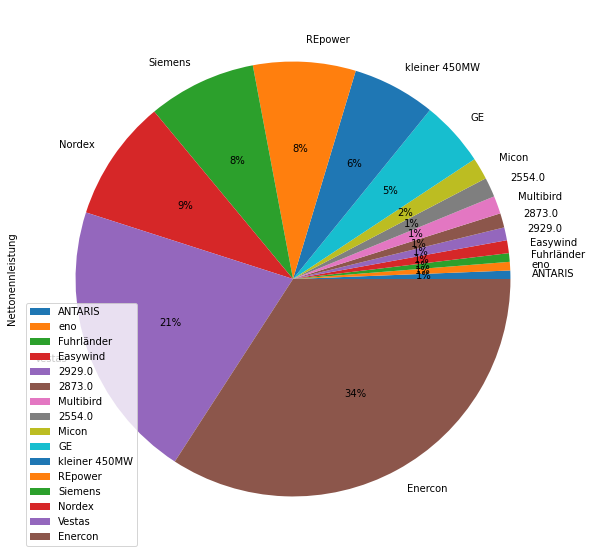

In [46]:
hersteller = {
    1572:"Multibird",
    1581:"BARD",
    1582:"ANTARIS",
    1584:"DeWind",
    1585:"Easywind",
    1586:"Enercon",
    1587:"eno",
    1588:"Eovent",
    1590:"Osiris",
    1592:"Frisia",
    1593:"Fuhrländer",
    1594:"Skywind",
    1596:"Gamesa",
    1597:"GE",
    1598:"GE",
    1601:"Heywind",
    1625:"Micon",
    1627:"Nordex",
    1628:"Nordex",
    1634:"EN-Drive",
    1644:"Seewind",
    1645:"REpower",
    1646:"Siemens",
    1660:"Vestas",
    2888:"REpower",
    2889:"AN Bonus",
    1654:"Tacke",
}

dummy = dfMastrWind.replace({"Hersteller": hersteller}).groupby("Hersteller").sum()[["Nettonennleistung","Anlagenzahl"]].sort_values(by="Nettonennleistung")
dummy = dummy.reset_index()

Grenzwert = 450
dummy.loc[dummy["Nettonennleistung"] < Grenzwert, "Hersteller"] = f"kleiner {Grenzwert}MW"
dummy = dummy.groupby("Hersteller").sum()
dummy.sort_values(by="Nettonennleistung").plot.pie(y="Nettonennleistung", figsize=(10,10), autopct="%1.0f%%")

#.to_excel("hersteller.xlsx")

In [4]:
dfMastrWind.loc[:,["Nettonennleistung","Rotordurchmesser","SpezifischeLeistung"]]

,Nettonennleistung,Rotordurchmesser,SpezifischeLeistung
0,4500.00,149.1,257.731408
1,2000.00,82.0,378.714915
2,600.00,44.0,394.599032
3,3075.00,112.0,312.118272
4,2.02,1.2,1786.072139
...,...,...,...
32978,2300.00,82.0,435.522152
32979,2300.00,70.0,597.643052
32980,750.00,48.0,414.465998
32981,2300.00,71.0,580.926593


# Analyse Repowering

In [25]:
datumsgrenze = "2000"

dfrep = dfMastrWind.loc[dfMastrWind["Inbetriebnahmedatum"] < datumsgrenze,:]
dfrep.groupby("Typenbezeichnung").count()["Anlagenzahl"].sort_values()

Typenbezeichnung
M750-250              1
M 1500-500/125        1
M 1500 600/150kw      1
M 1500 -600           1
Lagerway 80           1
                   ... 
TW600                90
E 40                111
E-40/5.40           150
E40                 173
E-40                230
Name: Anlagenzahl, Length: 788, dtype: int64

In [43]:
cond_modell = dfMastrWind["Typenbezeichnung"].str.contains("E48|E 48|E-48|e48|e 48|e-48", na=False)
cond_hersteller = dfMastrWind["Hersteller"] == 1586.0

dfrep = dfMastrWind.loc[cond_modell & cond_hersteller,:]
dfrep = dfrep[["EinheitMastrNummer","Inbetriebnahmedatum","Laengengrad","Breitengrad","Nabenhoehe","Bundesland"]].dropna(subset=["Laengengrad","Breitengrad","Nabenhoehe"])
dfrep["Typ"] = "Enercon E-48"
#dfrep.groupby("Bundesland").count()

,EinheitMastrNummer,Inbetriebnahmedatum,Laengengrad,Breitengrad,Nabenhoehe,Typ
Bundesland,,,,,,
Baden-Würtenberg,6,6,6,6,6,6
Bayern,5,5,5,5,5,5
Brandenburg,16,16,16,16,16,16
Hessen,5,5,5,5,5,5
Mecklenburg-Vorpommern,12,12,12,12,12,12
Niedersachsen,97,97,97,97,97,97
Nordrhein-Westfahlen,66,66,66,66,66,66
Rheinland-Pfalz,25,25,25,25,25,25
Sachsen,7,7,7,7,7,7


#  Anlagenbau Stark- / Schwachwindanlagen

In [15]:
def classify_Anlage(SpezifischeLeistung, grenze):
    if SpezifischeLeistung<=grenze: 
        Klasse ="Schwachwind"
    elif SpezifischeLeistung>grenze:
        Klasse ="Starkwindanlage"
    else:
        Klasse = numpy.NaN
    return Klasse

dfMastrWind["Groessenklasse"]=dfMastrWind.apply(lambda x: classify_Anlage(SpezifischeLeistung=x["SpezifischeLeistung"], grenze=150), axis=1)
dfMastrWind.loc[:,["SpezifischeLeistung", "Groessenklasse"]]

,SpezifischeLeistung,Groessenklasse
0,257.731408,Starkwindanlage
1,378.714915,Starkwindanlage
2,394.599032,Starkwindanlage
3,312.118272,Starkwindanlage
4,1786.072139,Starkwindanlage
...,...,...
32978,435.522152,Starkwindanlage
32979,597.643052,Starkwindanlage
32980,414.465998,Starkwindanlage
32981,580.926593,Starkwindanlage


# Analyse Windzubau nach Jahr, Monat und Bundesland

Onshore WEA sollen nach ihrem Zubaudatum (Jahr und Monat), sowie ihrem Bundesland gruppiert werden. 

Spalten die gebraucht werden:

- Bundesland
- Inbetriebnahmedatum
- Anzahl
- Nettonennleistung

In [7]:
onshoreWind = dfMastrWind[dfMastrWind["Seelage"].isna()]

onshoreWind.loc[:,"Inbetriebnahmedatum"] = onshoreWind["Inbetriebnahmedatum"].dt.strftime('%Y-%m')

onshoreWind = onshoreWind[["Bundesland","Inbetriebnahmedatum","Anlagenzahl", "Nettonennleistung"]]

onshoreWindGrouped = onshoreWind.groupby(["Bundesland","Inbetriebnahmedatum"]).sum()

/opt/anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
df = onshoreWindGrouped.reset_index()
all_continents = df["Bundesland"].unique()

fig = px.line(df, 
        x="Inbetriebnahmedatum", 
        y="Nettonennleistung", 
        color='Bundesland',
        color_discrete_sequence=px.colors.qualitative.Light24,height=470)

fig.show()

In [50]:
fig = px.line(df, 
        x="Inbetriebnahmedatum", 
        y="Anlagenzahl", 
        color='Bundesland',
        color_discrete_sequence=px.colors.qualitative.Light24,height=470)

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)'
    ),
    showlegend=True,
    plot_bgcolor='white'
)

fig.show()

In [7]:
onshoreWindGroupedPivot = onshoreWindGrouped.reset_index().pivot('Inbetriebnahmedatum','Bundesland','Anlagenzahl')
#onshoreWindGroupedPivot#.plot(figsize=(20,7), alpha=.5)
# create a new plot with a datetime axis type
onshoreWindGroupedPivot.index = pandas.to_datetime(onshoreWindGroupedPivot.index)

from bokeh.palettes import Category20b
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, Legend, ColumnDataSource

numlines=len(onshoreWindGroupedPivot.columns)
mypalette=Category20b[numlines]

fig = figure(
    width=1100, 
    height=500, 
    x_axis_type="datetime",
    toolbar_location="above", 
    tools="hover,save,pan,box_zoom,reset,wheel_zoom")
#fig.multi_line(
#    xs=[onshoreWindGroupedPivot.index.values]*numlines,
#    ys=[onshoreWindGroupedPivot[name].values for name in onshoreWindGroupedPivot.columns],
#    line_color=mypalette,)
df = onshoreWindGrouped.reset_index()
source = ColumnDataSource(df)

fig.vline_stack()
#legend = Legend(items=[(x, [x]) for x in onshoreWindGroupedPivot.columns])
#fig.add_layout(legend,'right')
#show(fig)

,Bundesland,Inbetriebnahmedatum,Anlagenzahl
0,Baden-Würtenberg,1989-07,1
1,Baden-Würtenberg,1991-05,1
2,Baden-Würtenberg,1992-10,1
3,Baden-Würtenberg,1993-06,1
4,Baden-Würtenberg,1994-09,1
...,...,...,...
3496,Thüringen,2021-06,2
3497,Thüringen,2021-08,2
3498,Thüringen,2021-10,2
3499,Thüringen,2021-12,3
